# Обязательная часть

## Скачивание файлов

In [ ]:
! sudo apt install clustalw bedtools proteinortho
! pip install biopython

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
import os

In [3]:
base = "http://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/"
paths = {
    "L_alkalisoli": "006/547/045/GCF_006547045.1_ASM654704v1",
    "L_antibioticus": "001/442/745/GCF_001442745.1_ASM144274v1",
    "L_arenosi": "016/613/475/GCF_016613475.2_ASM1661347v2",
    "L_capsici": "002/355/295/GCF_002355295.1_ASM235529v1",
    "L_caseinilyticus": "018/406/605/GCF_018406605.1_ASM1840660v1"
}
genomic_end = "_genomic.fna.gz"
feature_end = "_feature_table.txt.gz"
protein_end = "_protein.faa.gz"

! mkdir -p genomes histograms zhunt_result TSS intersect ortho clusters/raw clusters/aligned pictures

In [4]:
for key in paths.keys():
    os.system(f"wget -c -nv {base}{paths[key]}/{paths[key].split('/')[-1]}{genomic_end} -O 'genomes/{key}{genomic_end}'")
    os.system(f"wget -c -nv {base}{paths[key]}/{paths[key].split('/')[-1]}{feature_end} -O 'genomes/{key}{feature_end}'")
    os.system(f"gzip -f -d genomes/{key}{genomic_end}")
    os.system(f"gzip -f -d genomes/{key}{feature_end}")

In [5]:
for key in paths.keys():
    os.system(f"wget -c -nv {base}{paths[key]}/{paths[key].split('/')[-1]}{protein_end} -O 'genomes/{key}{protein_end}'")
    os.system(f"gzip -f -d genomes/{key}{protein_end}")

## Анализ аннотированных геномов

In [6]:
genomes_list = list(paths.keys())

In [7]:
def annot_analyse(genome):
    features = pd.read_csv(f"genomes/{genome}_feature_table.txt", sep='\t')
    features = features.loc[
        (features['# feature']=='gene') & 
        (features['seq_type']=='chromosome')
    ]
    seqs = [seq_record for seq_record in SeqIO.parse(f"genomes/{genome}_genomic.fna", "fasta")]
    # Choose complete genome, remove plasmids

    genome_len = max(list(map(lambda x: len(x.seq), seqs)))
    total_len = sum(list(map(lambda x: len(x.seq), seqs)))

    total_genes_len = features["feature_interval_length"].sum()

    return [len(features), round(total_genes_len/genome_len*100, 2), genome_len, total_len, len(seqs)]


In [8]:
annot_dict = dict()
for genome in genomes_list:
    annot_dict[genome] = annot_analyse(genome)

pd.DataFrame(annot_dict, 
index=["Genes number", "Genome coverage", 
"Genome length", "Genome + plasmid length", "Number of sequences"]
)

,L_alkalisoli,L_antibioticus,L_arenosi,L_capsici,L_caseinilyticus
Genes number,3429.0,4892.00,3604.00,5200.00,3186.00
Genome coverage,88.7,84.71,90.57,83.81,92.36
Genome length,3857091.0,5916388.00,3947892.00,6270417.00,3270651.00
Genome + plasmid length,3857091.0,5916388.00,3947892.00,6270417.00,3270651.00
Number of sequences,1.0,1.00,1.00,1.00,1.00


## Предсказание участков Z-DNA

In [9]:
os.system("wget -c -nv https://raw.githubusercontent.com/vanya-antonov/hse22-project/main/zhunt3-alan.c")

0

In [10]:
os.system("gcc zhunt3-alan.c -lm -o zhunt3")

0

In [11]:
import os
import subprocess
import tempfile
from pathlib import Path
from subprocess import DEVNULL, PIPE

ZH_EXECUTABLE = Path("../content/zhunt3")
assert ZH_EXECUTABLE.is_file()


def zhunt(query: str, windowsize: int = 6, minsize: int = 3, maxsize: int = 6):
    assert set(query).issubset({"A", "C", "G", "T", "N"})
    fd, temp = tempfile.mkstemp()
    os.close(fd)
    with open(temp, 'w') as stream:
        stream.write(query)

    subprocess.run(
        [ZH_EXECUTABLE, 
         str(windowsize), str(minsize), str(maxsize), temp],
        check=True, stdout=PIPE, stderr=DEVNULL,
        input=query, encoding='ascii'
    )
    with open(temp + ".Z-SCORE", 'r') as stream:
        df = pd.read_csv(stream,
                         names=['Start', 'End', 'nu-1', 'nu-2', 'nu-3', 
                                'ZH-Score', 'Sequence', 'Conformation'],
                         skiprows=1, sep='\s+')
    os.remove(temp)
    os.remove(temp + ".Z-SCORE")
    df = df.loc[df["ZH-Score"] > 500]
    return df[['Start', 'End', 'ZH-Score', 'Sequence', 'Conformation']]

In [12]:
def choose_max_seq(genome):
    seqs = [str(seq_record.seq) for seq_record in SeqIO.parse(f"genomes/{genome}_genomic.fna", "fasta")]
    # Choose complete genome, remove plasmids
    max_scaffold = max(seqs, key=len)
    return max_scaffold

In [13]:
zhunt_dict = dict()
for genome in genomes_list:
    zhunt_dict[genome] = zhunt(choose_max_seq(genome))

In [14]:
zhunt_dict[genomes_list[0]]

,Start,End,ZH-Score,Sequence,Conformation
7,8,20,1290.7690,gctccgtgcgcg,SAASASASASAS
8,9,21,2378.1490,ctccgtgcgcgc,SASASASASASA
9,10,22,21591.5200,tccgtgcgcgcg,ASASASASASAS
10,11,21,3372.1870,ccgtgcgcgc,SASASASASA
11,12,22,28780.5000,cgtgcgcgcg,ASASASASAS
...,...,...,...,...,...
3856755,3856756,3856764,980.8116,gcgcgcgg,SASASASA
3856756,3856757,3856763,883.5764,cgcgcg,ASASAS
3857043,3857044,3857056,645.7266,gtgcttgcgcgc,SASASASASASA
3857047,3857048,3857056,516.0707,ttgcgcgc,SASASASA


In [15]:
def process_zhunt_data(df):
    df = df.sort_values(["End", "Start"], ascending=True)

    # Count length with overlapping positions
    pos = 0
    length = 0
    for i, row in df.iterrows():
        if row.Start > pos:
            length += row.End - row.Start + 1
            pos = row.End
        elif row.Start < pos and row.End > pos:
            length += row.End - pos + 1
            pos = row.End
    
    return [len(df), length]

In [16]:
zhunt_stats = dict()
for genome in genomes_list:
    zhunt_stats[genome] = process_zhunt_data(zhunt_dict[genome])

pd.DataFrame(zhunt_stats, index=["Number of Z-DNA regions (with overlaps)", "Z-DNA length"])

,L_alkalisoli,L_antibioticus,L_arenosi,L_capsici,L_caseinilyticus
Number of Z-DNA regions (with overlaps),64696,130767,88526,179013,135193
Z-DNA length,241223,462124,316891,605008,455886


### Рисуем гистограммы

In [17]:
sns.set_theme()
for genome in genomes_list:
    sns.histplot(data=zhunt_dict[genome], x="ZH-Score", bins=30, log_scale=True)
    plt.title(genome.replace('_', '. ')+" ZH-Scores")
    plt.savefig(f"histograms/{genome}.png", dpi=400)
    plt.close()

### Сохраняем данные и создаём .bed файлы

In [18]:
for genome in genomes_list:
    zhunt_dict[genome].to_csv(f"zhunt_result/{genome}.zhunt.txt", index=None)

In [19]:
for genome in genomes_list:
    df = zhunt_dict[genome].copy()
    bed_df = pd.DataFrame(
        {
            "chrom": [genome] * len(df),
            "chromStart": df.Start,
            "chromEnd": df.End,
            "name": df.index,
            "score": df["ZH-Score"]
        }
    )

    bed_df.to_csv(f"zhunt_result/{genome}.zhunt.bed", index=None, sep='\t')


### Объединяем пересечения

In [20]:
for genome in genomes_list:
    os.system(f"bedtools merge -c 5 -o max -i zhunt_result/{genome}.zhunt.bed > zhunt_result/{genome}.zhunt.merged.bed")

## Ассоциируем предсказанные участки Z-DNA с промоторами генов

In [ ]:
features_dict = dict()

for genome in genomes_list:
    features = pd.read_csv(f"genomes/{genome}_feature_table.txt", sep='\t')
    features = features.loc[
        (features['seq_type']=='chromosome')
    ]
    locuses = list(np.unique(features.locus_tag))
    df = features.copy()

    counter = 1
    for locus in locuses:
        prod = list(features['product_accession'].loc[features.locus_tag == locus].dropna())
        if prod == []:
            prod = ["RNA" + str(counter)]
            counter += 1
            df['product_accession'].loc[df.locus_tag == locus] = prod[0]
        elif len(prod) == 1:
            df['product_accession'].loc[df.locus_tag == locus] = prod[0]
        else:
            print(prod)
    df = df.loc[df['# feature'] == 'gene']
    df = df[["# feature", "class" , "start", "end", "strand", "product_accession", "locus_tag"]]
    features_dict[genome] = df

In [22]:
for genome in genomes_list:
    features_dict[genome]['TSS'] = features_dict[genome].apply(lambda x: x.start if x.strand == "+" else x.end, axis=1)

In [23]:
for genome in genomes_list:
    df = features_dict[genome].copy()
    bed_df = pd.DataFrame(
        {
            "chrom": [genome] * len(df),
            "chromStart": df.TSS,
            "chromEnd": df.TSS,
            "name": df.product_accession
        }
    )

    bed_df.to_csv(f"TSS/{genome}.bed", index=None, header=None, sep='\t')

In [24]:
pd.DataFrame(
    {
        "Species": genomes_list,
        "Len": [annot_dict[genome][2] for genome in genomes_list]
    }
).to_csv(f"TSS/my.genomes", index=None, header=None, sep='\t')

In [25]:
for genome in genomes_list:
    os.system(f"bedtools slop -g TSS/my.genomes -i TSS/{genome}.bed -b 100 > TSS/{genome}.slop.bed")
    os.system(f"bedtools intersect -a TSS/{genome}.slop.bed -b zhunt_result/{genome}.zhunt.merged.bed -wb > intersect/{genome}.inter.bed")

## Создаём кластеры

In [26]:
!proteinortho5 -project=lysobacter genomes/*faa
!mv lysobacter* ortho/

*****************************************************************
Proteinortho with PoFF version 5.16 - An orthology detection tool
*****************************************************************
Detected 2 available CPU threads, Detected NCBI BLAST version 2.6.0+
Checking input files
Checking genomes/L_alkalisoli_protein.faa... ok
Checking genomes/L_antibioticus_protein.faa... ok
Checking genomes/L_arenosi_protein.faa... ok
Checking genomes/L_capsici_protein.faa... ok
Checking genomes/L_caseinilyticus_protein.faa... ok

**Step 1**
Generating indices
Building database for 'genomes/L_capsici_protein.faa'	(5048 sequences)
Building database for 'genomes/L_antibioticus_protein.faa'	(4762 sequences)
Building database for 'genomes/L_arenosi_protein.faa'	(3423 sequences)
Building database for 'genomes/L_alkalisoli_protein.faa'	(3266 sequences)
Building database for 'genomes/L_caseinilyticus_protein.faa'	(3088 sequences)

**Step 2**
Running blast analysis: 100% (10/10)
[OUTPUT] -> written to

### Статистика по кластерам

In [27]:
clusters = pd.read_csv("ortho/lysobacter.proteinortho", sep='\t')
clusters.sort_values("Alg.-Conn.", ascending=False, inplace=True)
clusters.reset_index(drop=True, inplace=True)
clusters.head(5)

,# Species,Genes,Alg.-Conn.,L_alkalisoli_protein.faa,L_antibioticus_protein.faa,L_arenosi_protein.faa,L_capsici_protein.faa,L_caseinilyticus_protein.faa
0,5,5,1.0,WP_005913193.1,WP_010342887.1,WP_010342887.1,WP_010342887.1,WP_010342887.1
1,4,4,1.0,WP_141623410.1,WP_057917780.1,*,WP_157753927.1,WP_213434710.1
2,2,2,1.0,*,WP_057917678.1,*,WP_157753916.1,*
3,2,2,1.0,*,WP_057917693.1,*,WP_232526192.1,*
4,2,2,1.0,*,WP_057917698.1,*,WP_157753921.1,*


In [28]:
number_of_clusters = len(clusters)
number_of_clusters

4191

In [29]:
sns.set_theme()
sns.countplot(data=clusters, x="# Species")
plt.title("Distribution of species in clusters")
#plt.xticks(ticks=[2, 3, 4, 5], labels=['2', '3', '4', '5'])
plt.tight_layout()
plt.savefig(f"histograms/clusters.png", dpi=400)
plt.close()

### Пересекаем кластеры и Z-DNA

In [30]:
clusters = pd.read_csv("ortho/lysobacter.proteinortho", sep='\t')
clusters = clusters.loc[clusters['# Species']==5]
clusters.sort_values("Alg.-Conn.", ascending=False, inplace=True)
clusters.reset_index(drop=True, inplace=True)
clusters.head(5)

,# Species,Genes,Alg.-Conn.,L_alkalisoli_protein.faa,L_antibioticus_protein.faa,L_arenosi_protein.faa,L_capsici_protein.faa,L_caseinilyticus_protein.faa
0,5,5,1.0,WP_005913193.1,WP_010342887.1,WP_010342887.1,WP_010342887.1,WP_010342887.1
1,5,5,1.0,WP_141624624.1,WP_057916303.1,WP_200607593.1,WP_096416766.1,WP_213436418.1
2,5,5,1.0,WP_141624658.1,WP_057916263.1,WP_200607627.1,WP_036113311.1,WP_213436963.1
3,5,5,1.0,WP_141624654.1,WP_031373271.1,WP_200607621.1,WP_096416914.1,WP_213436955.1
4,5,5,1.0,WP_141624652.1,WP_057916267.1,WP_200607619.1,WP_096416911.1,WP_213436953.1


In [31]:
def read_zdna_df(genome):
    zdna = pd.read_csv(f"intersect/{genome}.inter.bed", sep='\t', 
                names=["Sp1", "St1", "En1", "Protein", "Sp2", "Start", "End", f"Score_{genome}"]
                )[["Protein", f"Score_{genome}", "Start", "End"]]
    zdna.sort_values(f"Score_{genome}", ascending=False, inplace=True)
    # Drop duplicate proteins, keep maximal score
    zdna.drop_duplicates(subset='Protein', inplace=True)
    zdna.set_index("Protein", inplace=True)
    return zdna

In [32]:
for genome in genomes_list:
    zdna = read_zdna_df(genome)[f"Score_{genome}"]
    list_of_zhscores = [float(zdna.loc[prot]) if prot in list(zdna.index) else None for prot in clusters[f"{genome}_protein.faa"]]
    clusters[f"{genome}_protein.score"] = list_of_zhscores
clusters.head()

,# Species,Genes,Alg.-Conn.,L_alkalisoli_protein.faa,L_antibioticus_protein.faa,L_arenosi_protein.faa,L_capsici_protein.faa,L_caseinilyticus_protein.faa,L_alkalisoli_protein.score,L_antibioticus_protein.score,L_arenosi_protein.score,L_capsici_protein.score,L_caseinilyticus_protein.score
0,5,5,1.0,WP_005913193.1,WP_010342887.1,WP_010342887.1,WP_010342887.1,WP_010342887.1,NaN,NaN,NaN,NaN,904.3200
1,5,5,1.0,WP_141624624.1,WP_057916303.1,WP_200607593.1,WP_096416766.1,WP_213436418.1,NaN,NaN,NaN,NaN,27872.6600
2,5,5,1.0,WP_141624658.1,WP_057916263.1,WP_200607627.1,WP_036113311.1,WP_213436963.1,NaN,NaN,NaN,657.1159,NaN
3,5,5,1.0,WP_141624654.1,WP_031373271.1,WP_200607621.1,WP_096416914.1,WP_213436955.1,1030.205,NaN,3428.529,1202.5920,3428.5290
4,5,5,1.0,WP_141624652.1,WP_057916267.1,WP_200607619.1,WP_096416911.1,WP_213436953.1,3428.529,13713.99,1737.612,13713.9900,908.3955


In [33]:
chosen = clusters.dropna(subset=clusters.columns[-5:])
chosen

,# Species,Genes,Alg.-Conn.,L_alkalisoli_protein.faa,L_antibioticus_protein.faa,L_arenosi_protein.faa,L_capsici_protein.faa,L_caseinilyticus_protein.faa,L_alkalisoli_protein.score,L_antibioticus_protein.score,L_arenosi_protein.score,L_capsici_protein.score,L_caseinilyticus_protein.score
4,5,5,1.000,WP_141624652.1,WP_057916267.1,WP_200607619.1,WP_096416911.1,WP_213436953.1,3428.5290,13713.9900,1737.612,13713.990,908.3955
6,5,5,1.000,WP_141624643.1,WP_057916294.1,WP_200607615.1,WP_096418628.1,WP_213436407.1,783.8230,3661.1100,2752.447,38833.580,46858.5200
11,5,5,1.000,WP_141624623.1,WP_031372121.1,WP_200607589.1,WP_036105763.1,WP_213436420.1,2752.4470,883.5764,13713.990,38833.580,13713.9900
18,5,5,1.000,WP_141624615.1,WP_057916316.1,WP_200607554.1,WP_096416734.1,WP_213436440.1,980.8116,3428.5290,4553.390,3428.529,883.5764
19,5,5,1.000,WP_141624614.1,WP_057919852.1,WP_200607552.1,WP_096416731.1,WP_213436442.1,883.5764,38833.5800,8485.756,12351.130,65884.1100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,5,5,0.200,WP_244244119.1,WP_187308397.1,WP_245156897.1,WP_157754006.1,WP_213434318.1,883.5764,13713.9900,2752.447,13713.990,3428.5290
1511,5,5,0.200,WP_244244117.1,WP_057917585.1,WP_200604871.1,WP_096414179.1,WP_213434294.1,2943.4610,2943.4610,963.953,2943.461,13713.9900
1515,5,5,0.200,WP_141624072.1,WP_057918936.1,WP_200606565.1,WP_157754114.1,WP_244858640.1,7973.0840,941334.2000,302785.500,4545.701,38833.5800
1530,5,5,0.166,WP_141622900.1,WP_082647894.1,WP_200605577.1,WP_096414788.1,WP_213434488.1,698.7317,980.8116,13713.990,2962.843,8485.7560


### Выравниваем белки

In [34]:
aa_seqs = dict()
for genome in genomes_list:
    aa_seqs[genome] = SeqIO.to_dict(SeqIO.parse(f"genomes/{genome}_protein.faa", "fasta"))


In [35]:
counter = 1

for i, row in chosen.iterrows():
    seqs_in_cluster = []
    for genome in genomes_list:
        protein_id = row[f"{genome}_protein.faa"]
        seqs_in_cluster.append(aa_seqs[genome][protein_id])
    SeqIO.write(seqs_in_cluster, f"clusters/raw/cluster_{counter}.faa", "fasta")
    counter += 1

In [36]:
for cl in range(1,9):
    os.system(f"clustalw -align -type=PROTEIN -infile='clusters/raw/cluster_{cl}.faa' -OUTFILE='clusters/aligned/cluster_{cl}.aln'")

### Визуализируем

In [ ]:
!pip install dna_features_viewer
from dna_features_viewer import GraphicFeature, GraphicRecord

In [38]:
zdna_dict = dict()
for genome in genomes_list:
    features_dict[genome].set_index("product_accession", drop=False, inplace=True)
    zdna_dict[genome] = read_zdna_df(genome)

In [39]:
chosen = clusters.dropna(subset=clusters.columns[-5:])
medians = chosen.iloc[:, 8:13].median(axis=1)
chosen["median_score"] = medians
chosen.sort_values("median_score", ascending=False, inplace=True)
chosen = chosen.iloc[:10,:]
chosen

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,# Species,Genes,Alg.-Conn.,L_alkalisoli_protein.faa,L_antibioticus_protein.faa,L_arenosi_protein.faa,L_capsici_protein.faa,L_caseinilyticus_protein.faa,L_alkalisoli_protein.score,L_antibioticus_protein.score,L_arenosi_protein.score,L_capsici_protein.score,L_caseinilyticus_protein.score,median_score
711,5,5,1.0,WP_141622338.1,WP_057919224.1,WP_200608951.1,WP_096412712.1,WP_244858736.1,302785.50,18180.9500,94590.410,302785.500,302785.500,302785.50
420,5,5,1.0,WP_141623009.1,WP_057918688.1,WP_207527048.1,WP_096415080.1,WP_213435310.1,302785.50,138924.1000,28780.500,138924.100,28780.500,138924.10
61,5,5,1.0,WP_141625219.1,WP_057916805.1,WP_200607005.1,WP_036106629.1,WP_213436222.1,1228.72,138924.1000,588.503,138924.100,198956.200,138924.10
256,5,5,1.0,WP_141623927.1,WP_057917522.1,WP_200606400.1,WP_046656180.1,WP_213434228.1,4615.40,138924.1000,138924.100,138924.100,4615.400,138924.10
97,5,5,1.0,WP_141624913.1,WP_057919803.1,WP_200608085.1,WP_096417986.1,WP_213436825.1,941334.20,138924.1000,66470.780,13713.990,138924.100,138924.10
392,5,5,1.0,WP_141623803.1,WP_057918573.1,WP_207527056.1,WP_096414981.1,WP_213434275.1,138924.10,138924.1000,138924.100,138924.100,138924.100,138924.10
137,5,5,1.0,WP_141624790.1,WP_187308536.1,WP_200608147.1,WP_198339037.1,WP_213434195.1,138924.10,138924.1000,138924.100,27872.660,1512.188,138924.10
849,5,5,1.0,WP_141623731.1,WP_031370490.1,WP_200604731.1,WP_096414918.1,WP_213435118.1,13713.99,138924.1000,739.950,138924.100,138924.100,138924.10
592,5,5,1.0,WP_141622384.1,WP_082638491.1,WP_200608786.1,WP_096412847.1,WP_213433368.1,302785.50,883.5764,302785.500,1116.621,138924.100,138924.10
160,5,5,1.0,WP_141624889.1,WP_057916201.1,WP_200607751.1,WP_096417070.1,WP_213436684.1,65884.11,13713.9900,302785.500,13713.990,66470.780,65884.11


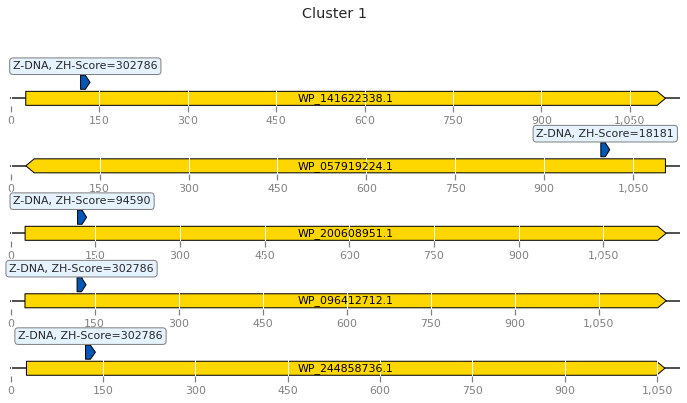

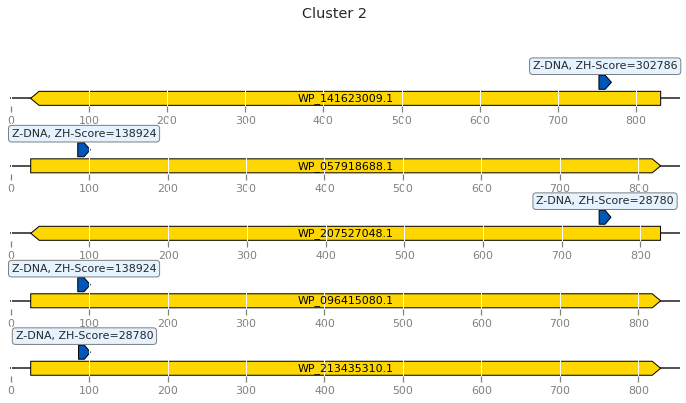

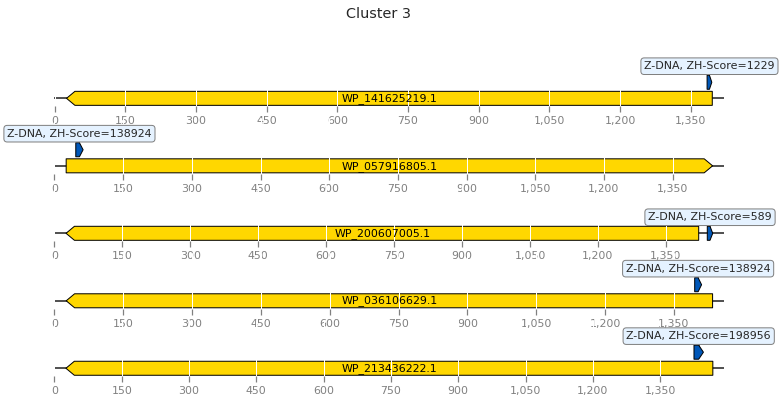

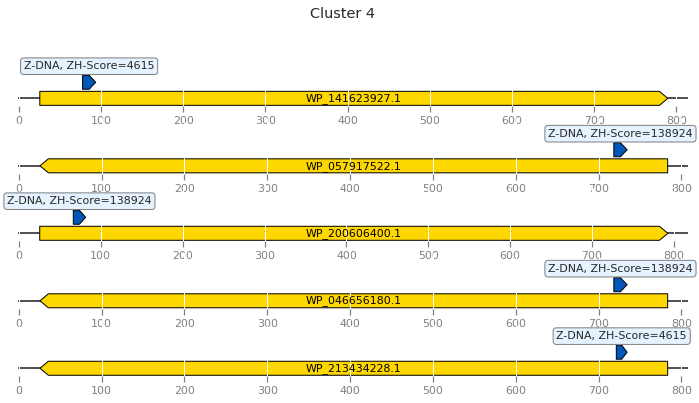

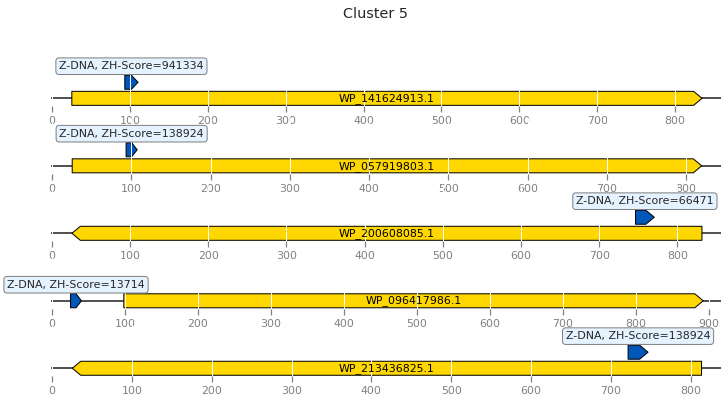

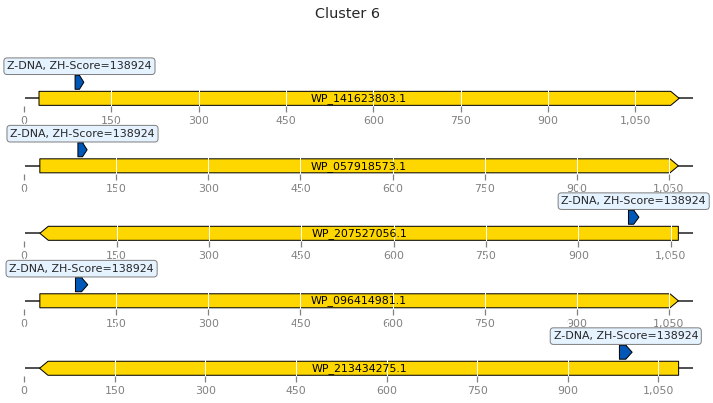

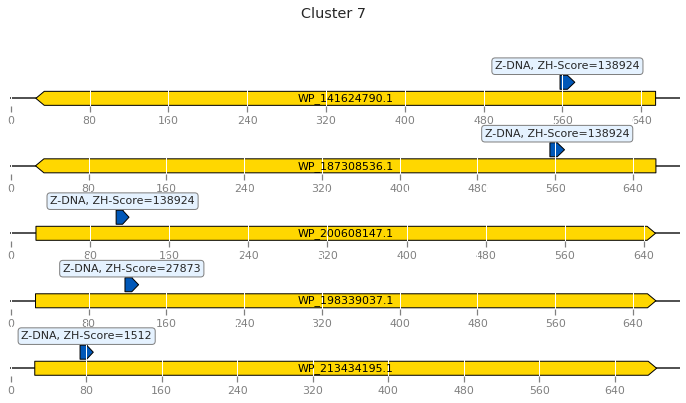

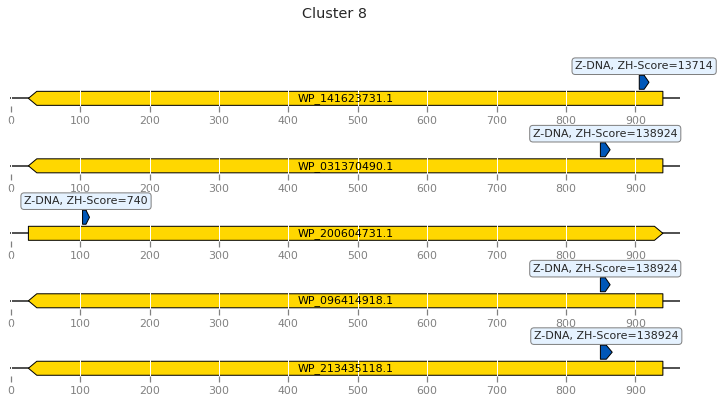

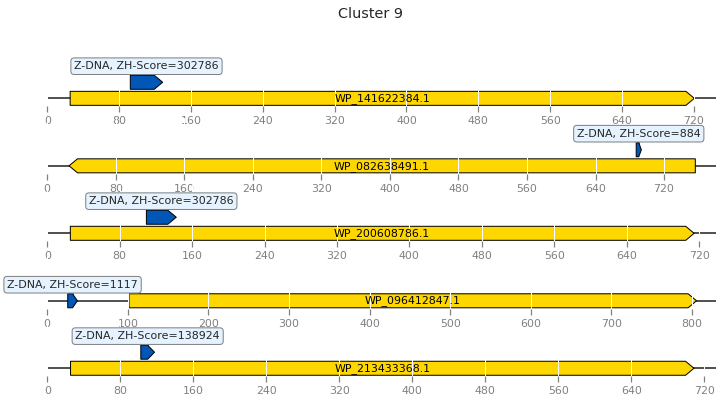

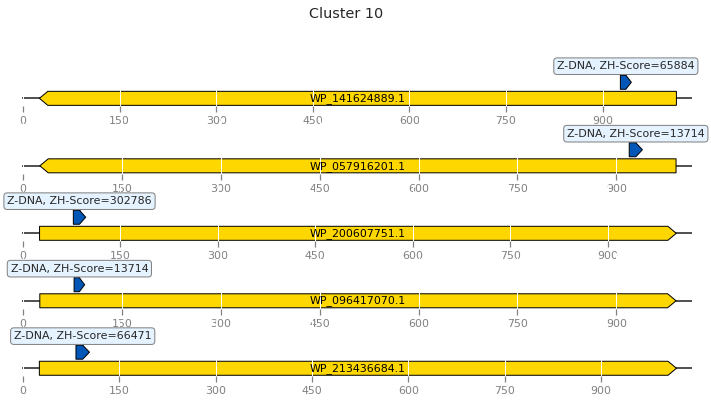

In [40]:
counter = 1
for k, row in chosen.iterrows():
    fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(12, 6))
    fig.suptitle(f'Cluster {counter}')

    for i, genome in enumerate(genomes_list):
        zdna = zdna_dict[genome]
        features = features_dict[genome]

        prot = row.loc[genome + '_protein.faa']
        Z_DNA_label = "Z-DNA, ZH-Score=" + str(round(zdna.loc[prot][f"Score_{genome}"]))
        coords = [zdna.loc[prot, "Start"], zdna.loc[prot, "End"],
                  features.loc[prot, "start"], features.loc[prot, "end"]]
        minimum = min(coords)

        strand = +1 if features.loc[prot, "strand"]=="+" else -1

        features=[
        GraphicFeature(start=coords[0]-minimum+26, end=coords[1]-minimum+26, 
                   strand=+1, color="#0057b8", label=Z_DNA_label),
        GraphicFeature(start=coords[2]-minimum+26, end=coords[3]-minimum+26, 
                   strand=strand, color="#ffd700", label=prot),
                   ]
        record = GraphicRecord(sequence_length=max(coords)-minimum+50, features=features)
        record.plot(ax=axes[i])
    plt.savefig(f'pictures/Cluster_{counter}.png', dpi=500)
    counter += 1

# Бонусная часть

## Поиск G-квадруплексов

In [41]:
na_seqs = dict()
for genome in genomes_list:
    na_seqs[genome] = choose_max_seq(genome)

### Ставим PQSfinder и запускаем

In [ ]:
!wget https://raw.githubusercontent.com/narek01/hse22_project/main/configure.r
!wget https://raw.githubusercontent.com/narek01/hse22_project/main/pqsfinder.r

In [ ]:
! Rscript configure.r

In [44]:
import os
import subprocess
import tempfile
from pathlib import Path
from subprocess import DEVNULL, PIPE

Q_EXECUTABLE = Path("pqsfinder.r")
assert Q_EXECUTABLE.is_file()


def pqs(query: str):
    assert set(query).issubset({"A", "C", "G", "T", "N"})
    fd, temp = tempfile.mkstemp()
    os.close(fd)
    with open(temp, 'w') as stream:
        stream.write(">chr\n"+query)

    subprocess.run(
        ["Rscript", Q_EXECUTABLE, temp, temp + ".qgrs"],
        check=True, stdout=PIPE, stderr=DEVNULL,
        input=query, encoding='ascii'
    )
    
    with open(temp + ".qgrs", 'r') as stream:
        df = pd.read_csv(stream,
                         #names=['ID', 'T1', 'T2', 'T3', 'T4', 'TS', 'GS', 'SEQ'],
                         skiprows=0, sep=' ').iloc[:,:8]
    os.remove(temp)
    os.remove(temp + ".qgrs")
    #df = df.loc[df["score"] > 500]
    #return df
    return df[['start', 'end', 'score', 'strand']]

In [45]:
pqs_dict = dict()
for genome in genomes_list:
    pqs_dict[genome] = pqs(na_seqs[genome])

In [46]:
def process_pqs_data(df):
    df = df.sort_values(["end", "start"], ascending=True)

    # Count length with overlapping positions
    pos = 0
    length = 0
    for i, row in df.iterrows():
        if row.start > pos:
            length += row.end - row.start + 1
            pos = row.end
        elif row.start < pos and row.end > pos:
            length += row.end - pos + 1
            pos = row.end
    
    return [len(df), length]

In [47]:
pqs_stats = dict()
for genome in genomes_list:
    pqs_stats[genome] = process_pqs_data(pqs_dict[genome])

pd.DataFrame(pqs_stats, index=["Number of quadruplex regions (with overlaps)", "Quadruplex length"])

,L_alkalisoli,L_antibioticus,L_arenosi,L_capsici,L_caseinilyticus
Number of quadruplex regions (with overlaps),284,426,194,816,285
Quadruplex length,6545,9781,4554,18673,6575


Рисуем гистограммы

In [48]:
sns.set_theme()
for genome in genomes_list:
    sns.histplot(data=pqs_dict[genome], x="score", bins=30, log_scale=False)
    plt.title(genome.replace('_', '. ')+" Quadruplex Scores")
    plt.savefig(f"histograms/{genome}_quadruplex.png", dpi=400)
    plt.close()

Сохраняем данные и создаём .bed файлы

In [49]:
! mkdir -p pqs_result
for genome in genomes_list:
    pqs_dict[genome].to_csv(f"pqs_result/{genome}.pqs.txt", index=None)

In [50]:
for genome in genomes_list:
    df = pqs_dict[genome].copy()
    bed_df = pd.DataFrame(
        {
            "chrom": [genome] * len(df),
            "chromStart": df.start,
            "chromEnd": df.end,
            "name": df.index,
            "score": df.score,
            "strand": df.strand
        }
    )

    bed_df.to_csv(f"pqs_result/{genome}.pqs.bed", index=None, sep='\t')

Объединяем пересечения

In [51]:
for genome in genomes_list:
    os.system(f"bedtools merge -c 5,6 -o max,distinct -i pqs_result/{genome}.pqs.bed > pqs_result/{genome}.pqs.merged.bed")

Ассоциируем предсказанные участки квадруплексов с промоторами генов

In [52]:
for genome in genomes_list:
    os.system(f"bedtools intersect -a TSS/{genome}.slop.bed -b pqs_result/{genome}.pqs.merged.bed -wb > intersect/{genome}_quadruplex.inter.bed")

In [53]:
def read_pqs_df(genome):
    pqs = pd.read_csv(f"intersect/{genome}_quadruplex.inter.bed", sep='\t', 
                names=["Sp1", "St1", "En1", "Protein", "Sp2", "Start", "End", f"Score_{genome}", "Strand"]
                )[["Protein", f"Score_{genome}", "Start", "End", "Strand"]]
    pqs.sort_values(f"Score_{genome}", ascending=False, inplace=True)
    # Drop duplicate proteins, keep maximal score
    pqs.drop_duplicates(subset='Protein', inplace=True)
    pqs.set_index("Protein", inplace=True)
    return pqs

In [54]:
for genome in genomes_list:
    pqs = read_pqs_df(genome)[f"Score_{genome}"]
    list_of_scores = [float(pqs.loc[prot]) if prot in list(pqs.index) else None for prot in clusters[f"{genome}_protein.faa"]]
    clusters[f"{genome}_protein.quadro"] = list_of_scores
clusters.head()

,# Species,Genes,Alg.-Conn.,L_alkalisoli_protein.faa,L_antibioticus_protein.faa,L_arenosi_protein.faa,L_capsici_protein.faa,L_caseinilyticus_protein.faa,L_alkalisoli_protein.score,L_antibioticus_protein.score,L_arenosi_protein.score,L_capsici_protein.score,L_caseinilyticus_protein.score,L_alkalisoli_protein.quadro,L_antibioticus_protein.quadro,L_arenosi_protein.quadro,L_capsici_protein.quadro,L_caseinilyticus_protein.quadro
0,5,5,1.0,WP_005913193.1,WP_010342887.1,WP_010342887.1,WP_010342887.1,WP_010342887.1,NaN,NaN,NaN,NaN,904.3200,NaN,NaN,NaN,NaN,NaN
1,5,5,1.0,WP_141624624.1,WP_057916303.1,WP_200607593.1,WP_096416766.1,WP_213436418.1,NaN,NaN,NaN,NaN,27872.6600,57.0,NaN,NaN,60.0,NaN
2,5,5,1.0,WP_141624658.1,WP_057916263.1,WP_200607627.1,WP_036113311.1,WP_213436963.1,NaN,NaN,NaN,657.1159,NaN,NaN,64.0,NaN,NaN,NaN
3,5,5,1.0,WP_141624654.1,WP_031373271.1,WP_200607621.1,WP_096416914.1,WP_213436955.1,1030.205,NaN,3428.529,1202.5920,3428.5290,NaN,NaN,NaN,NaN,NaN
4,5,5,1.0,WP_141624652.1,WP_057916267.1,WP_200607619.1,WP_096416911.1,WP_213436953.1,3428.529,13713.99,1737.612,13713.9900,908.3955,NaN,NaN,NaN,NaN,NaN


In [59]:
chosen = clusters.dropna(subset=clusters.columns[-5:], how="all", thresh=4)
chosen

,# Species,Genes,Alg.-Conn.,L_alkalisoli_protein.faa,L_antibioticus_protein.faa,L_arenosi_protein.faa,L_capsici_protein.faa,L_caseinilyticus_protein.faa,L_alkalisoli_protein.score,L_antibioticus_protein.score,L_arenosi_protein.score,L_capsici_protein.score,L_caseinilyticus_protein.score,L_alkalisoli_protein.quadro,L_antibioticus_protein.quadro,L_arenosi_protein.quadro,L_capsici_protein.quadro,L_caseinilyticus_protein.quadro
743,5,5,1.0,WP_141622279.1,WP_057919305.1,WP_200609076.1,WP_096412280.1,WP_213437229.1,NaN,1737.612,NaN,NaN,NaN,NaN,60.0,61.0,63.0,64.0


Визуализируем


In [56]:
from dna_features_viewer import GraphicFeature, GraphicRecord
quadro_dict = dict()
for genome in genomes_list:
    features_dict[genome].set_index("product_accession", drop=False, inplace=True)
    quadro_dict[genome] = read_pqs_df(genome)

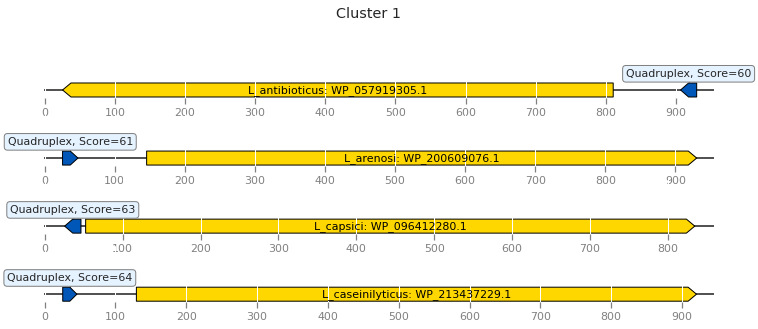

In [57]:
counter = 1
for k, row in chosen.iterrows():
    rows_num = len(row.iloc[-5:].dropna())
    fig, axes = plt.subplots(nrows=rows_num, ncols=1,figsize=(12, 6*rows_num/5))
    fig.suptitle(f'Cluster {counter}')
    axes_count = 0

    for i, genome in enumerate(genomes_list):
        quad = quadro_dict[genome]
        features = features_dict[genome]

        prot = row.loc[genome + '_protein.faa']
        if not prot in quad.index:
            continue

        quad_label = "Quadruplex, Score=" + str(round(quad.loc[prot][f"Score_{genome}"]))
        coords = [quad.loc[prot, "Start"], quad.loc[prot, "End"],
                  features.loc[prot, "start"], features.loc[prot, "end"]]
        minimum = min(coords)

        strand_q = +1 if quad.loc[prot, "Strand"]=="+" else -1
        strand_f = +1 if features.loc[prot, "strand"]=="+" else -1


        features=[
        GraphicFeature(start=coords[0]-minimum+26, end=coords[1]-minimum+26, 
                   strand=strand_q, color="#0057b8", label=quad_label),
        GraphicFeature(start=coords[2]-minimum+26, end=coords[3]-minimum+26, 
                   strand=strand_f, color="#ffd700", label=genome + ": " + prot),
                   ]
        record = GraphicRecord(sequence_length=max(coords)-minimum+50, features=features)
        record.plot(ax=axes[axes_count])
        axes_count += 1
    plt.savefig(f'pictures/Cluster_{counter}_quadruplex.png', dpi=500)
    counter += 1